# Import libraries

In [1]:
# from scapy.all import *
# import dpkt
from PIL import Image
import binascii
from datetime import datetime, timedelta, timezone
import pytz
import os
from typing import *

import pandas as pd
import numpy as np
from scipy.fftpack import ifft, idct
from sklearn.preprocessing import MinMaxScaler
from torchvision import transforms

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import random

# from sklearn.model_selection import train_test_split  

# Utils

In [2]:
def create_destination_folder(path: str) -> None:
  if not os.path.isdir(path):
    print("Create folder: [%s]" % path)
    os.mkdir(path)
  else:
    print("Remove existing folder and create new folder: [%s]" % path)
    for root, dirs, files in os.walk(path, topdown=False):
      for name in files:
          os.remove(os.path.join(root, name))
      for name in dirs:
          os.rmdir(os.path.join(root, name))
    os.rmdir(path)
    os.mkdir(path)

In [3]:
def show_images(images, titles, fig_title, figsize=(20,10), columns = 5):
  fig = plt.figure(figsize=figsize)
  fig.suptitle(fig_title, fontsize=15)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.axis('off')
      plt.title(titles[i])
      plt.imshow(image)

In [4]:
def convert_and_save_aggr(array: Union[np.ndarray, list], method: Callable[[np.ndarray, list], tuple], matrix_size: tuple, path: str) -> None:
  normal_path = os.path.join(path, 'normal')
  create_destination_folder(normal_path)
  attack_path = os.path.join(path, 'attack')
  create_destination_folder(attack_path)

  idx = 0
  for sample in array:
    target = sample[-1]
    features = sample[:-4]
    ts = str(sample[-4])
    image = method(features, matrix_size)
    if target == 0:
      save_path = normal_path
      image_name = '%s.jpg' % ts
    else:  
      save_path = attack_path
      attack_type = int(sample[-2])
      image_name = '%s_%s.jpg' % (ts, attack_type)
    image.save(os.path.join(save_path, image_name))
    if idx != 0 and idx % 1000 == 0:
      print("%s samples converted to images and saved" % idx)
    idx += 1

In [5]:
def convert_and_save(array: Union[np.ndarray, list], method: Callable[[np.ndarray, list], tuple], matrix_size: tuple, path: str) -> None:
  normal_path = os.path.join(path, 'normal')
  create_destination_folder(normal_path)
  attack_path = os.path.join(path, 'attack')
  create_destination_folder(attack_path)

  idx = 0
  for sample in array:
    target = sample[-1]
    features = sample[:-3]
    ts = str(sample[-3])
    image = method(features, matrix_size)
    if target == 0:
      save_path = normal_path
      image_name = '%s.jpg' % ts
    else:  
      save_path = attack_path
      attack_type = int(sample[-2])
      image_name = '%s_%s.jpg' % (ts, attack_type)
    image.save(os.path.join(save_path, image_name))
    if idx != 0 and idx % 1000 == 0:
      print("%s samples converted to images and saved" % idx)
    idx += 1

In [6]:
def linear_transformation(sample: Union[np.ndarray, list], size=tuple) -> Image:
  if type(sample) == list:
    sample = np.array(sample)
  sample_pixel_range = sample  # * 255
  sample_pixel_range_reshaped = sample_pixel_range.reshape(size)
  image = Image.fromarray(obj=sample_pixel_range_reshaped.astype(np.uint8), 
                          mode='L')
  # image_resized = image.resize((224, 224))
  rgb_image = image.convert('RGB')
  return rgb_image

In [7]:
def diagonal_transformation(sample: Union[np.ndarray, list], size=tuple) -> Image:
  if type(sample) == list:
    sample = np.array(sample)
  sample_pixel_range = sample  # * 255
  
  matrix = np.zeros(size)
  for r in range(min(size)):
    for i, j in zip(range(r, -1, -1), range(r+1)):
      matrix[i, j] = sample_pixel_range[0]
      sample_pixel_range = sample_pixel_range[1:]

  image = Image.fromarray(obj=matrix.astype(np.uint8), 
                          mode='L')
  # image_resized = image.resize((224, 224))
  rgb_image = image.convert('RGB')
  return rgb_image

In [8]:
def diagonal_transformation_with_idct(sample: Union[np.ndarray, list], size=tuple) -> Image:
  if type(sample) == list:
    sample = np.array(sample)
  sample_pixel_range = sample  # * 255
  
  matrix = np.zeros(size)
  for r in range(min(size)):
    for i, j in zip(range(r, -1, -1), range(r+1)):
      matrix[i, j] = sample_pixel_range[0]
      sample_pixel_range = sample_pixel_range[1:]

  image = Image.fromarray(obj=idct(matrix).astype(np.uint8), 
                          mode='L')
  # image_resized = image.resize((224, 224))
  rgb_image = image.convert('RGB')
  return rgb_image

In [9]:
def zigzag_transformation(sample: Union[np.ndarray, list], size=tuple) -> Image:
  if type(sample) == list:
    sample = np.array(sample)
  if size[0] == size[1]:  # and size[0] % 2 == 1:
    t_size = size[0]
    sample_pixel_range = sample  # * 255

    matrix = np.zeros(size)
    moves = [(0, 1), (1, -1), (1, 0), (-1, 1)]
    moves_length = [1, 1, 1, 1]
    reverse = False
    i, j = 0, 0
    matrix[i, j] = sample_pixel_range[0]
    sample_pixel_range = sample_pixel_range[1:]
    move_id = 0
    while True:
      for c in range(moves_length[move_id]):
        if len(sample_pixel_range) < 1:
          break
        i += moves[move_id][0]
        j += moves[move_id][1]
        if i < t_size and i >= 0 and j < t_size and j >= 0:
          matrix[i, j] = sample_pixel_range[0]
          sample_pixel_range = sample_pixel_range[1:]

      if move_id == 1 or move_id == 3:
        if reverse:
          moves_length[1] -= 1
          moves_length[3] -= 1
        else:
          moves_length[1] += 1
          moves_length[3] += 1
          if moves_length[1] == t_size or moves_length[3] == t_size:
            reverse = True
            temp = moves[0]
            moves[0] = moves[2]
            moves[2] = temp
      
      move_id += 1
      if move_id == 4:
        move_id = 0

      if i >= t_size - 1 and j >= t_size - 1:
        break
      
    image = Image.fromarray(obj=matrix.astype(np.uint8), 
                            mode='L')
    # image_resized = image.resize((224, 224))
    rgb_image = image.convert('RGB')
    return rgb_image

In [10]:
def zigzag_transformation_with_idct(sample: Union[np.ndarray, list], size=tuple) -> Image:
  if type(sample) == list:
    sample = np.array(sample)
  if size[0] == size[1]:  # and size[0] % 2 == 1:
    t_size = size[0]
    sample_pixel_range = sample  # * 255

    matrix = np.zeros(size)
    moves = [(0, 1), (1, -1), (1, 0), (-1, 1)]
    moves_length = [1, 1, 1, 1]
    reverse = False
    i, j = 0, 0
    matrix[i, j] = sample_pixel_range[0]
    sample_pixel_range = sample_pixel_range[1:]
    move_id = 0
    while True:
      for c in range(moves_length[move_id]):
        if len(sample_pixel_range) < 1:
          break
        i += moves[move_id][0]
        j += moves[move_id][1]
        if i < t_size and i >= 0 and j < t_size and j >= 0:
          matrix[i, j] = sample_pixel_range[0]
          sample_pixel_range = sample_pixel_range[1:]

      if move_id == 1 or move_id == 3:
        if reverse:
          moves_length[1] -= 1
          moves_length[3] -= 1
        else:
          moves_length[1] += 1
          moves_length[3] += 1
          if moves_length[1] == t_size or moves_length[3] == t_size:
            reverse = True
            temp = moves[0]
            moves[0] = moves[2]
            moves[2] = temp
      
      move_id += 1
      if move_id == 4:
        move_id = 0

      if i >= t_size - 1 and j >= t_size - 1:
        break
      
    image = Image.fromarray(obj=idct(matrix).astype(np.uint8), 
                            mode='L')
    # image_resized = image.resize((224, 224))
    rgb_image = image.convert('RGB')
    return rgb_image

In [11]:
def spiral_transformation(sample: Union[np.ndarray, list], size=tuple) -> Image:
  if type(sample) == list:
    sample = np.array(sample)
  if size[0] == size[1]:  # and size[0] % 2 == 1:
    t_size = size[0]
    sample_pixel_range = sample  # * 255

    matrix = np.zeros(size)
    moves = ((0, -1), (1, 0), (0, 1), (-1, 0))
    moves_length = [1, 1, 1, 1]
    center = t_size // 2
    i, j = center, center
    matrix[i, j] = sample_pixel_range[0]
    sample_pixel_range = sample_pixel_range[1:]
    move_id = 0
    while True:
      for c in range(moves_length[move_id]):
        if len(sample_pixel_range) < 1:
          break
        i += moves[move_id][0]
        j += moves[move_id][1]
        if i < t_size and i >= 0 and j < t_size and j >= 0:
          matrix[i, j] = sample_pixel_range[0]
          sample_pixel_range = sample_pixel_range[1:]

      if move_id == 0 or move_id == 2:
        moves_length[0] += 1
        moves_length[2] += 1
      else:
        moves_length[1] += 1
        moves_length[3] += 1
      
      move_id += 1
      if move_id == 4:
        move_id = 0

      if moves_length[0] > t_size and moves_length[1] > t_size:
        break
      
    image = Image.fromarray(obj=matrix.astype(np.uint8), 
                            mode='L')
    # image_resized = image.resize((224, 224))
    rgb_image = image.convert('RGB')
    return rgb_image

# Connect to Google Drive (if needed)

In [12]:
# Подключить к google colab содержимое вашего google диск
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


# Aggregation through collected packets with mean 

## Show images

In [ ]:
experimental_array_agg_p_ts = np.loadtxt('/content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/aggregated/dataset_agg_p_ts_experimental.csv', delimiter=',', dtype=np.float64)
experimental_array_agg_p_ts.shape

(17943, 328)

In [ ]:
attack_idxs_agg_p_ts = list()
normal_idxs_agg_p_ts = list()
idx = 0
while idx < len(experimental_array_agg_p_ts):
  if experimental_array_agg_p_ts[idx, -1] == 1:
    attack_idxs_agg_p_ts.append(idx)
  else:
    normal_idxs_agg_p_ts.append(idx)
  idx += 1

In [ ]:
RESOLUTION = 13

offset = 328 - RESOLUTION**2 

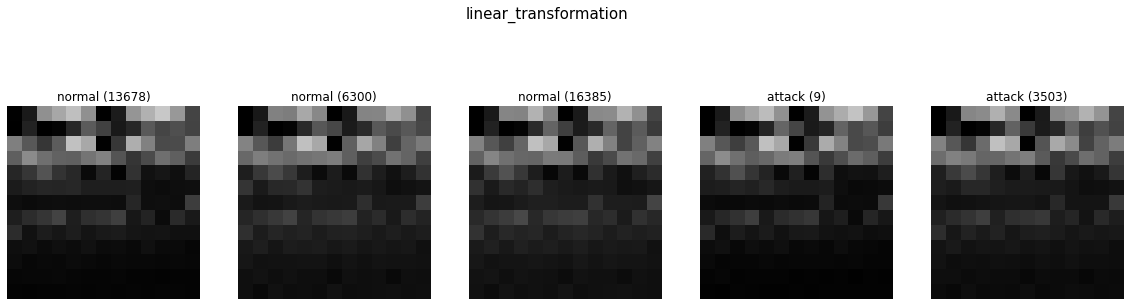

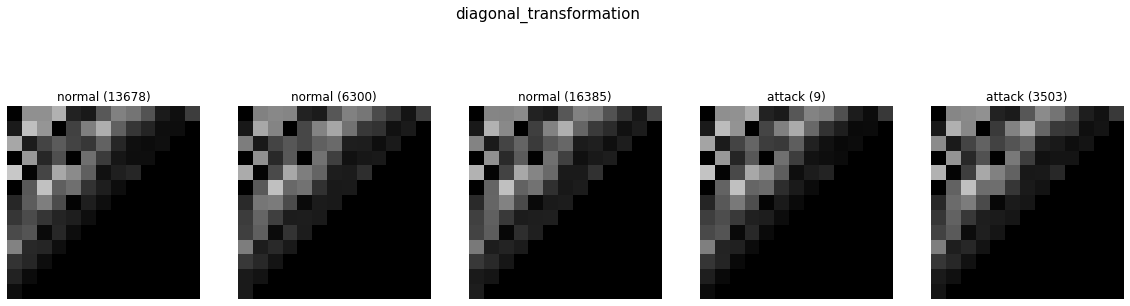

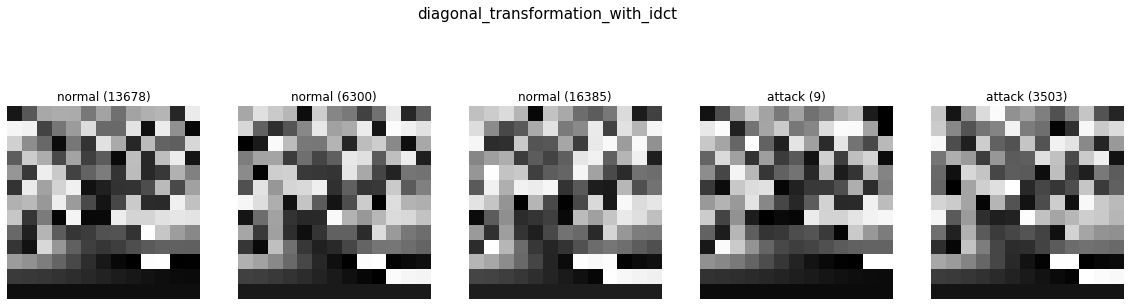

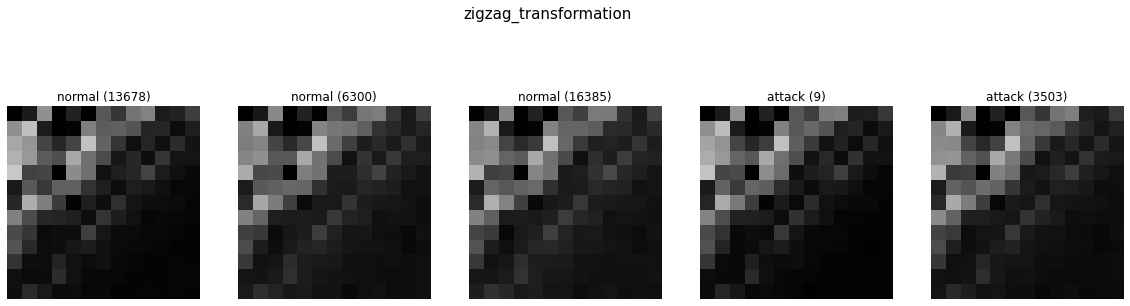

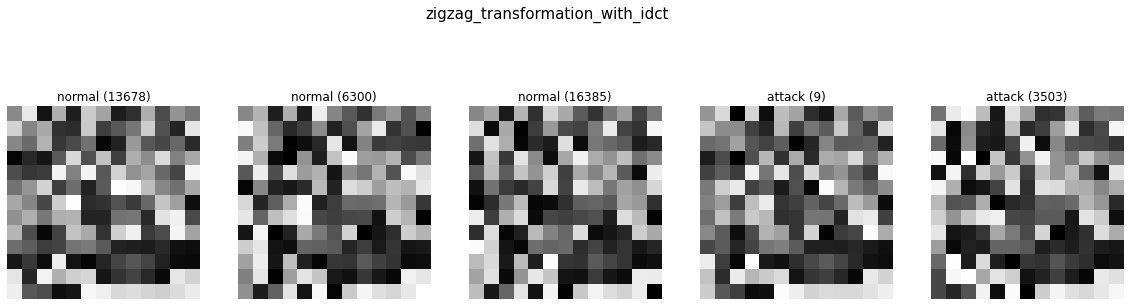

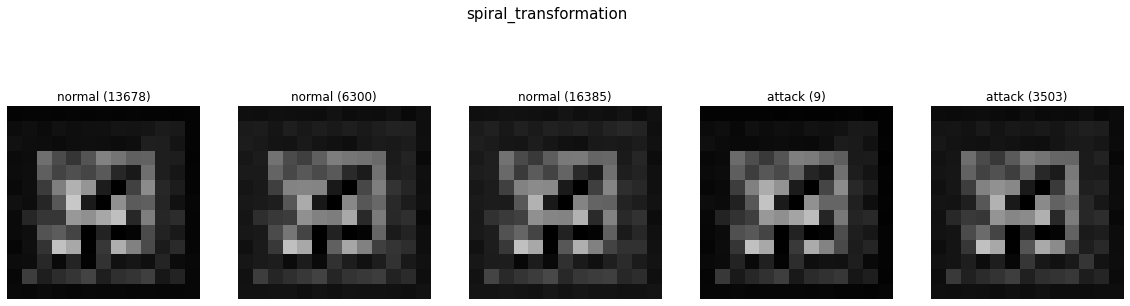

In [ ]:
random_normal = random.sample(normal_idxs_agg_p_ts, 3) 
random_attack = random.sample(attack_idxs_agg_p_ts, 2) 

functions = [linear_transformation, 
             diagonal_transformation, 
             diagonal_transformation_with_idct,
             zigzag_transformation,
             zigzag_transformation_with_idct,  
             spiral_transformation]

for func in functions:
  images = list()
  titles = list()
  for idx in random_normal:
    images.append(func(sample=experimental_array_agg_p_ts[idx, : -offset], size=(RESOLUTION, RESOLUTION)))
    titles.append('normal (%s)' % idx)
  for idx in random_attack:
    images.append(func(sample=experimental_array_agg_p_ts[idx, : -offset], size=(RESOLUTION, RESOLUTION)))
    titles.append('attack (%s)' % idx)
  show_images(images=images, titles=titles, fig_title=func.__name__)

## Prepare data to CNN

### Split dataset to train/test

We want to split the data in the following ratios:
- train=70%, test=30%
- normal=60%, attack=40%

In [ ]:
random.seed(77)

In [ ]:
experimental_array_agg_p_ts = np.loadtxt('/content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/aggregated/dataset_agg_p_ts_experimental.csv', delimiter=',', dtype=np.float64)
experimental_array_agg_p_ts.shape

(17943, 328)

In [ ]:
attack_idxs_agg_p_ts = list()
normal_idxs_agg_p_ts = list()
idx = 0
while idx < len(experimental_array_agg_p_ts):
  if experimental_array_agg_p_ts[idx, -1] == 1:
    attack_idxs_agg_p_ts.append(idx)
  else:
    normal_idxs_agg_p_ts.append(idx)
  idx += 1

In [ ]:
attack_count = len(attack_idxs_agg_p_ts)
normal_count = len(normal_idxs_agg_p_ts)
attack_percentage = round(len(attack_idxs_agg_p_ts) / (len(attack_idxs_agg_p_ts) + len(normal_idxs_agg_p_ts)) * 100, 2)

print('Attack samples count: %s' % attack_count)
print('Normal samples count: %s' % normal_count)
print('Attack samples percentage: %s%%' % attack_percentage)

Attack samples count: 5986
Normal samples count: 11957
Attack samples percentage: 33.36%


Calculate the right amount of normal samples

In [ ]:
temp_count = int(attack_count / 0.4 - attack_count)
print('Right amount of normal samples to do easy train test split: %s' % temp_count)

Right amount of normal samples to do easy train test split: 8979


Choose random normal samples

In [ ]:
normal_idxs_agg_p_ts_balanced = random.sample(normal_idxs_agg_p_ts, temp_count) 

In [ ]:
attack_count = len(attack_idxs_agg_p_ts)
normal_count_balanced = len(normal_idxs_agg_p_ts_balanced)
attack_percentage_balanced = round(len(attack_idxs_agg_p_ts) / (len(attack_idxs_agg_p_ts) + len(normal_idxs_agg_p_ts_balanced)) * 100, 2)

print('Attack samples count: %s' % attack_count)
print('Normal samples count: %s' % normal_count_balanced)
print('Attack samples percentage: %s%%' % attack_percentage_balanced)

Attack samples count: 5986
Normal samples count: 8979
Attack samples percentage: 40.0%


Split balanced data

In [ ]:
train_experimental_agg_p_ts_normal_count = int(normal_count_balanced * 0.7)
train_experimental_agg_p_ts_attack_count = int(attack_count * 0.7)

In [ ]:
train_experimental_agg_p_ts_idxs = np.append(random.sample(normal_idxs_agg_p_ts_balanced, train_experimental_agg_p_ts_normal_count),
                                             random.sample(attack_idxs_agg_p_ts, train_experimental_agg_p_ts_attack_count))
np.random.shuffle(train_experimental_agg_p_ts_idxs)

In [ ]:
all_idxs_agg_p_ts_balanced = np.append(normal_idxs_agg_p_ts_balanced, attack_idxs_agg_p_ts)
test_experimental_agg_p_ts_idxs = all_idxs_agg_p_ts_balanced[~np.isin(all_idxs_agg_p_ts_balanced, train_experimental_agg_p_ts_idxs)]
np.random.shuffle(test_experimental_agg_p_ts_idxs)

In [ ]:
print('Final ratios:')
print('Train=%s%%, test=%s%%' % (round(train_experimental_agg_p_ts_idxs.shape[0] / (train_experimental_agg_p_ts_idxs.shape[0] + test_experimental_agg_p_ts_idxs.shape[0]) * 100, 2),
                             round(test_experimental_agg_p_ts_idxs.shape[0] / (train_experimental_agg_p_ts_idxs.shape[0] + test_experimental_agg_p_ts_idxs.shape[0]) * 100, 2)))
print('Inside train: normal=%s%%, attack=%s%%' % (round(train_experimental_agg_p_ts_idxs[~np.isin(train_experimental_agg_p_ts_idxs, 
                                                                                                  attack_idxs_agg_p_ts)].shape[0] / train_experimental_agg_p_ts_idxs.shape[0] * 100, 2),
                                                  round(train_experimental_agg_p_ts_idxs[~np.isin(train_experimental_agg_p_ts_idxs, 
                                                                                                  normal_idxs_agg_p_ts)].shape[0] / train_experimental_agg_p_ts_idxs.shape[0] * 100, 2)))
print('Inside test: normal=%s%%, attack=%s%%' % (round(test_experimental_agg_p_ts_idxs[~np.isin(test_experimental_agg_p_ts_idxs, 
                                                                                                 attack_idxs_agg_p_ts)].shape[0] / test_experimental_agg_p_ts_idxs.shape[0] * 100, 2),
                                                 round(test_experimental_agg_p_ts_idxs[~np.isin(test_experimental_agg_p_ts_idxs, 
                                                                                                 normal_idxs_agg_p_ts)].shape[0] / test_experimental_agg_p_ts_idxs.shape[0] * 100, 2)))

Final ratios:
Train=70.0%, test=30.0%
Inside train: normal=60.0%, attack=40.0%
Inside test: normal=60.0%, attack=40.0%


In [ ]:
train_experimental_agg_p_ts_dataset = experimental_array_agg_p_ts[train_experimental_agg_p_ts_idxs]
test_experimental_agg_p_ts_dataset = experimental_array_agg_p_ts[test_experimental_agg_p_ts_idxs]

### Convert data to images and save

Select parameters

In [ ]:
print('Max matrix size: %s' % int((train_experimental_agg_p_ts_dataset.shape[1] - 4)**0.5))

Max matrix size: 18


In [ ]:
METHOD = zigzag_transformation_with_idct  # zigzag_transformation_with_idct  # linear_transformation
DATASET_NAME = 'SWaT_Dec2019_agg_p_ts_experimental_image'
DESTINATION_FOLDER_NAME = DATASET_NAME + '_' + METHOD.__name__
MATRIX_SIZE = 18

In [ ]:
train_experimental_agg_p_ts_dataset.shape

(10475, 328)

Create destination folders

In [ ]:
train_experimental_path = DESTINATION_FOLDER_NAME + '_train'
create_destination_folder(train_experimental_path)

test_experimental_path = DESTINATION_FOLDER_NAME + '_test'
create_destination_folder(test_experimental_path)

Remove existing folder and create new folder: [SWaT_Dec2019_agg_p_ts_experimental_image_zigzag_transformation_with_idct_train]
Remove existing folder and create new folder: [SWaT_Dec2019_agg_p_ts_experimental_image_zigzag_transformation_with_idct_test]


In [ ]:
%%time
convert_and_save(array=train_experimental_agg_p_ts_dataset,
                 method=METHOD,
                 matrix_size=(MATRIX_SIZE, MATRIX_SIZE),
                 path=train_experimental_path)

Create folder: [SWaT_Dec2019_agg_p_ts_experimental_image_zigzag_transformation_with_idct_train/normal]
Create folder: [SWaT_Dec2019_agg_p_ts_experimental_image_zigzag_transformation_with_idct_train/attack]
1000 samples converted to images and saved
2000 samples converted to images and saved
3000 samples converted to images and saved
4000 samples converted to images and saved
5000 samples converted to images and saved
6000 samples converted to images and saved
7000 samples converted to images and saved
8000 samples converted to images and saved
9000 samples converted to images and saved
10000 samples converted to images and saved
CPU times: user 5.45 s, sys: 587 ms, total: 6.04 s
Wall time: 6.09 s


In [ ]:
%%time
convert_and_save(array=test_experimental_agg_p_ts_dataset,
                 method=METHOD,
                 matrix_size=(MATRIX_SIZE, MATRIX_SIZE),
                 path=test_experimental_path)

Create folder: [SWaT_Dec2019_agg_p_ts_experimental_image_zigzag_transformation_with_idct_test/normal]
Create folder: [SWaT_Dec2019_agg_p_ts_experimental_image_zigzag_transformation_with_idct_test/attack]
1000 samples converted to images and saved
2000 samples converted to images and saved
3000 samples converted to images and saved
4000 samples converted to images and saved
CPU times: user 2.28 s, sys: 280 ms, total: 2.56 s
Wall time: 2.57 s


In [ ]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
!tree "/content/SWaT_Dec2019_agg_p_ts_experimental_image_zigzag_transformation_with_idct_train" | tail -1

2 directories, 10475 files


In [ ]:
!tar -czvf "SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train.tar.gz" -C "/content" "SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train" 
!cp "/content/SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train.tar.gz" "/content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/images"

!tar -czvf "SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_test.tar.gz" -C "/content" "SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_test" 
!cp "/content/SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_test.tar.gz" "/content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/images"

Выходные данные были обрезаны до нескольких последних строк (5000).
SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train/attack/1575601271.364179_1.jpg
SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train/attack/1575601457.397274_1.jpg
SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train/attack/1575601252.100557_1.jpg
SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train/attack/1575601281.652342_1.jpg
SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train/attack/1575601480.321462_1.jpg
SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train/attack/1575601252.601782_1.jpg
SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train/attack/1575601358.66996_1.jpg
SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train/attack/1575601246.632496_1.jpg
SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train/attack/1575601362.73296_1.jpg
SWaT_Dec2019_agg_p_ts_experimental

## [NEW] Prepare data to CNN

In [ ]:
info_features_length = 4

### Split dataset to train/test

In [ ]:
%%time
test_array_ep = np.loadtxt('/content/drive/MyDrive/Master/MW_Semenov_6381/datasets/SWaT/SWaT_2019/aggregated/dataset_pp_ts.csv', delimiter=',', dtype=np.float64)
test_array_ep.shape

CPU times: user 19 s, sys: 2.02 s, total: 21 s
Wall time: 25.7 s


In [ ]:
train_experimental_ep_features, test_experimental_ep_features, train_experimental_ep_labels, test_experimental_ep_labels = train_test_split(test_array_ep[:, :-1], test_array_ep[:, -1], test_size=0.3)

In [ ]:
unique_train, counts_train = np.unique(train_experimental_ep_labels, return_counts=True)
unique_test, counts_test = np.unique(test_experimental_ep_labels, return_counts=True)

In [ ]:
print('Final ratios:')
print('Train=%s%%, test=%s%%' % (round(train_experimental_ep_labels.shape[0] / test_array_ep.shape[0] * 100, 2),
                                 round(test_experimental_ep_labels.shape[0] / test_array_ep.shape[0] * 100, 2)))
print('Inside train: normal=%s%%, attack=%s%%' % (round(counts_train[0] / train_experimental_ep_labels.shape[0] * 100, 2),
                                                  round(counts_train[1] / train_experimental_ep_labels.shape[0] * 100, 2)))
print('Inside test: normal=%s%%, attack=%s%%' % (round(counts_test[0] / test_experimental_ep_labels.shape[0] * 100, 2),
                                                 round(counts_test[1] / test_experimental_ep_labels.shape[0] * 100, 2)))

Final ratios:
Train=70.0%, test=30.0%
Inside train: normal=66.31%, attack=33.69%
Inside test: normal=67.42%, attack=32.58%


In [ ]:
train_experimental_ep_dataset = np.concatenate((train_experimental_ep_features, train_experimental_ep_labels.reshape(-1, 1)), axis=1)
test_experimental_ep_dataset = np.concatenate((test_experimental_ep_features, test_experimental_ep_labels.reshape(-1, 1)), axis=1)

In [ ]:
test_experimental_ep_dataset.shape

(5383, 1229)

### Convert data to images and save

Select parameters

In [ ]:
METHOD = linear_transformation  # zigzag_transformation  # linear_transformation  # spiral_transformation
DATASET_NAME = 'SWaT_Dec2019_pp_image_first121b'
DESTINATION_FOLDER_NAME = DATASET_NAME + '_' + METHOD.__name__
MATRIX_SIZE = int((test_array_ep.shape[1] - info_features_length)**0.5)

In [ ]:
print('Max matrix size: %s' % MATRIX_SIZE)
print('Destination folder name: %s' % DESTINATION_FOLDER_NAME)

Max matrix size: 35
Destination folder name: SWaT_Dec2019_pp_image_first121b_linear_transformation


Create destination folders

In [ ]:
train_experimental_path = DESTINATION_FOLDER_NAME + '_train'
create_destination_folder(train_experimental_path)

test_experimental_path = DESTINATION_FOLDER_NAME + '_test'
create_destination_folder(test_experimental_path)

Create folder: [SWaT_Dec2019_pp_image_first121b_linear_transformation_train]
Create folder: [SWaT_Dec2019_pp_image_first121b_linear_transformation_test]


In [ ]:
%%time
convert_and_save_aggr(array=train_experimental_ep_dataset,
                 method=METHOD,
                 matrix_size=(MATRIX_SIZE, MATRIX_SIZE),
                 path=train_experimental_path)

Create folder: [SWaT_Dec2019_pp_image_first121b_linear_transformation_train/normal]
Create folder: [SWaT_Dec2019_pp_image_first121b_linear_transformation_train/attack]
1000 samples converted to images and saved
2000 samples converted to images and saved
3000 samples converted to images and saved
4000 samples converted to images and saved
5000 samples converted to images and saved
6000 samples converted to images and saved
7000 samples converted to images and saved
8000 samples converted to images and saved
9000 samples converted to images and saved
10000 samples converted to images and saved
11000 samples converted to images and saved
12000 samples converted to images and saved
CPU times: user 2.48 s, sys: 764 ms, total: 3.25 s
Wall time: 3.25 s


In [ ]:
%%time
convert_and_save_aggr(array=test_experimental_ep_dataset,
                 method=METHOD,
                 matrix_size=(MATRIX_SIZE, MATRIX_SIZE),
                 path=test_experimental_path)

Create folder: [SWaT_Dec2019_pp_image_first121b_linear_transformation_test/normal]
Create folder: [SWaT_Dec2019_pp_image_first121b_linear_transformation_test/attack]
1000 samples converted to images and saved
2000 samples converted to images and saved
3000 samples converted to images and saved
4000 samples converted to images and saved
5000 samples converted to images and saved
CPU times: user 1.11 s, sys: 390 ms, total: 1.5 s
Wall time: 1.51 s


In [ ]:
# !sudo apt-get install tree

In [ ]:
!tree "/content/SWaT_Dec2019_pp_image_first121b_linear_transformation_train" | tail -1

2 directories, 12560 files


In [ ]:
!tree "/content/SWaT_Dec2019_pp_image_first121b_linear_transformation_test" | tail -1

2 directories, 5383 files


In [ ]:
!tar -czvf "SWaT_Dec2019_pp_image_first121b_linear_transformation_train.tar.gz" -C "/content" "SWaT_Dec2019_pp_image_first121b_linear_transformation_train" 
!cp "/content/SWaT_Dec2019_pp_image_first121b_linear_transformation_train.tar.gz" "/content/drive/MyDrive/Master/MW_Semenov_6381/datasets/SWaT/SWaT_2019/images"

!tar -czvf "SWaT_Dec2019_pp_image_first121b_linear_transformation_test.tar.gz" -C "/content" "SWaT_Dec2019_pp_image_first121b_linear_transformation_test" 
!cp "/content/SWaT_Dec2019_pp_image_first121b_linear_transformation_test.tar.gz" "/content/drive/MyDrive/Master/MW_Semenov_6381/datasets/SWaT/SWaT_2019/images"

Выходные данные были обрезаны до нескольких последних строк (5000).
SWaT_Dec2019_pp_image_first121b_linear_transformation_test/attack/1575601478.66416_1.jpg
SWaT_Dec2019_pp_image_first121b_linear_transformation_test/attack/1575601405.025141_1.jpg
SWaT_Dec2019_pp_image_first121b_linear_transformation_test/attack/1575601382.652901_1.jpg
SWaT_Dec2019_pp_image_first121b_linear_transformation_test/attack/1575601422.132324_1.jpg
SWaT_Dec2019_pp_image_first121b_linear_transformation_test/attack/1575601289.478031_1.jpg
SWaT_Dec2019_pp_image_first121b_linear_transformation_test/attack/1575601368.906375_1.jpg
SWaT_Dec2019_pp_image_first121b_linear_transformation_test/attack/1575601387.117911_1.jpg
SWaT_Dec2019_pp_image_first121b_linear_transformation_test/attack/1575601314.706273_1.jpg
SWaT_Dec2019_pp_image_first121b_linear_transformation_test/attack/1575601353.292308_1.jpg
SWaT_Dec2019_pp_image_first121b_linear_transformation_test/attack/1575601392.283144_1.jpg
SWaT_Dec2019_pp_image_first121b_l

# Aggregation one packet to one pixel with mean 

## Show images

In [ ]:
%%time
test_array_pp_ts = np.loadtxt('/content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/aggregated/dataset_pp_ts_experimental.csv', delimiter=',', dtype=np.float32)
test_array_pp_ts.shape

CPU times: user 32.2 s, sys: 3.92 s, total: 36.1 s
Wall time: 38.4 s


In [ ]:
%%time
attack_idxs_pp_ts = list()
normal_idxs_pp_ts = list()
idx = 0
while idx < len(test_array_pp_ts):
  if test_array_pp_ts[idx, -1] == 1:
    attack_idxs_pp_ts.append(idx)
  else:
    normal_idxs_pp_ts.append(idx)
  idx += 1

CPU times: user 56.4 ms, sys: 0 ns, total: 56.4 ms
Wall time: 68.6 ms


In [ ]:
RESOLUTION = 45

offset = 2029 - RESOLUTION**2

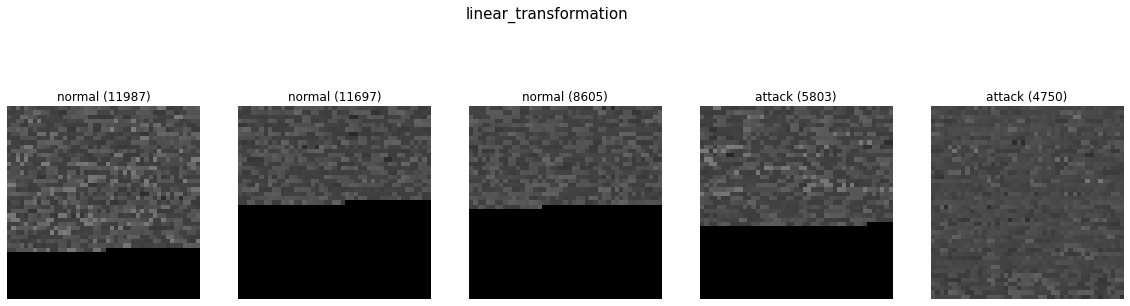

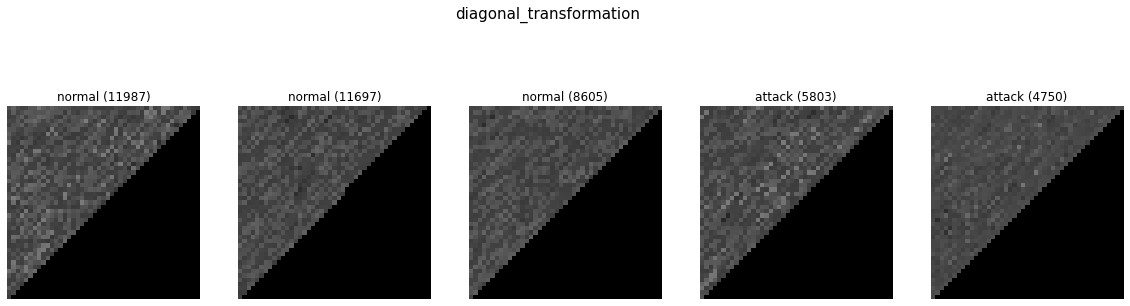

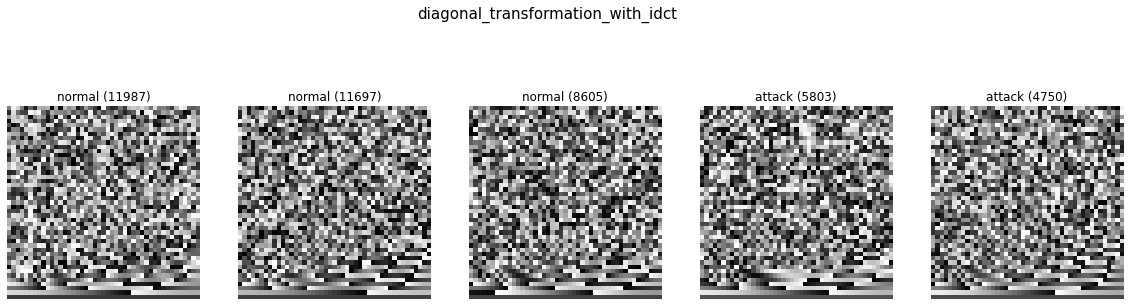

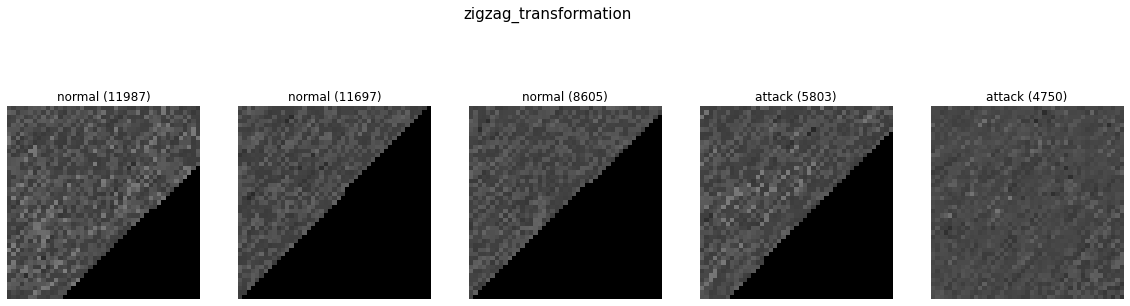

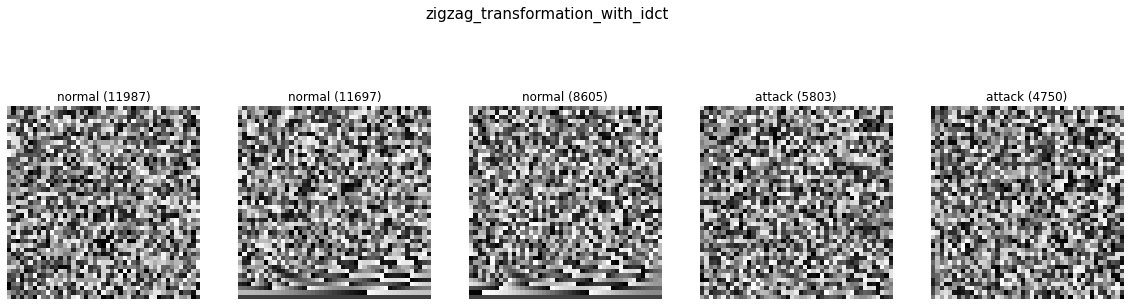

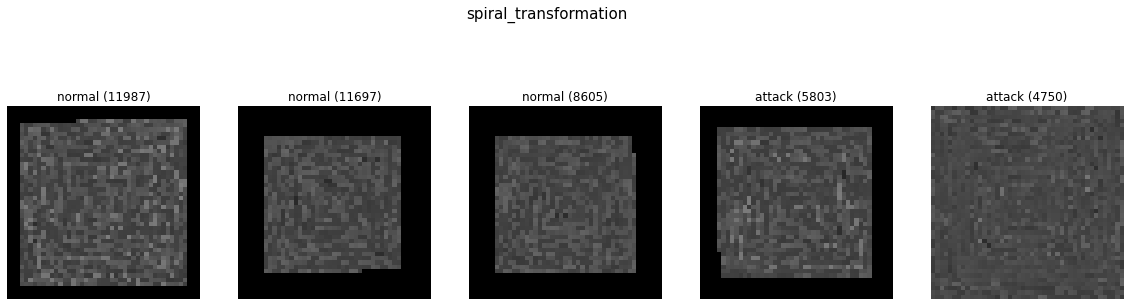

In [ ]:
random_normal = random.sample(normal_idxs_pp_ts, 3) 
random_attack = random.sample(attack_idxs_pp_ts, 2) 

functions = [linear_transformation, 
             diagonal_transformation, 
             diagonal_transformation_with_idct,
             zigzag_transformation,
             zigzag_transformation_with_idct, 
             spiral_transformation]

for func in functions:
  images = list()
  titles = list()
  for idx in random_normal:
    images.append(func(sample=test_array_pp_ts[idx, : -offset], size=(RESOLUTION, RESOLUTION)))
    titles.append('normal (%s)' % idx)
  for idx in random_attack:
    images.append(func(sample=test_array_pp_ts[idx, : -offset], size=(RESOLUTION, RESOLUTION)))
    titles.append('attack (%s)' % idx)
  show_images(images=images, titles=titles, fig_title=func.__name__)

# One packet = one feature

## Try different interpolation methods

In [ ]:
%%time
test_array_ep = np.loadtxt('/content/drive/MyDrive/Master/MW_Semenov_6381/datasets/SWaT/SWaT_2019/not_aggregated/dataset_ep_bin_clf_experimental_with_ip_first100b.csv', delimiter=',', dtype=np.float64)
print(test_array_ep.shape)

CPU times: user 8.85 s, sys: 841 ms, total: 9.69 s
Wall time: 11.6 s


In [ ]:
%%time
attack_idxs_ep = list()
normal_idxs_ep = list()
idx = 0
while idx < len(test_array_ep):
  if test_array_ep[idx, -1] == 1:
    attack_idxs_ep.append(idx)
  else:
    normal_idxs_ep.append(idx)
  idx += 1

CPU times: user 97.4 ms, sys: 3.38 ms, total: 101 ms
Wall time: 114 ms


In [ ]:
RESOLUTION = 10

offset = 103 - RESOLUTION**2

In [ ]:
str(transforms.InterpolationMode.BILINEAR)

'InterpolationMode.BILINEAR'

In [ ]:
def show_images(images, titles, fig_title, figsize=(20,10), columns = 5):
  fig = plt.figure(figsize=figsize)
  fig.suptitle(fig_title, fontsize=15)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.axis('off')
      plt.title(titles[i])
      plt.imshow(image)

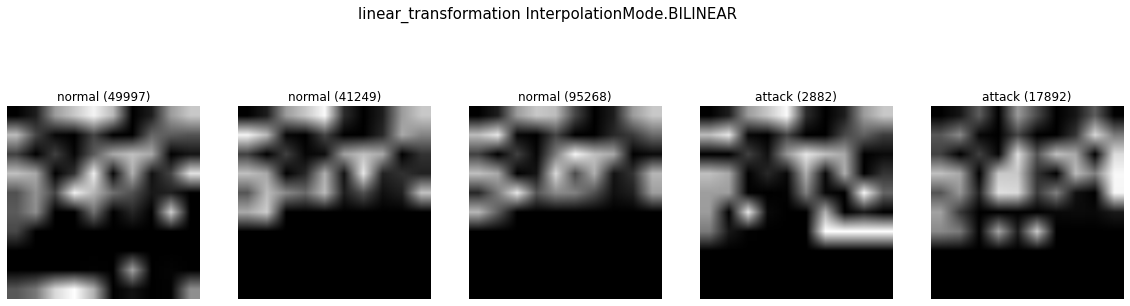

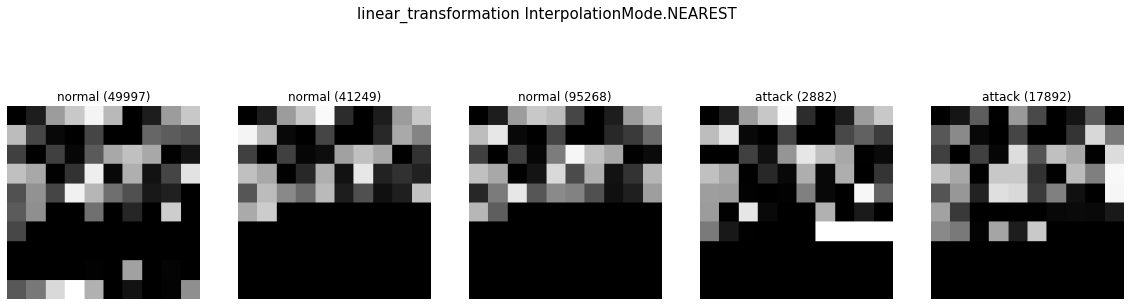

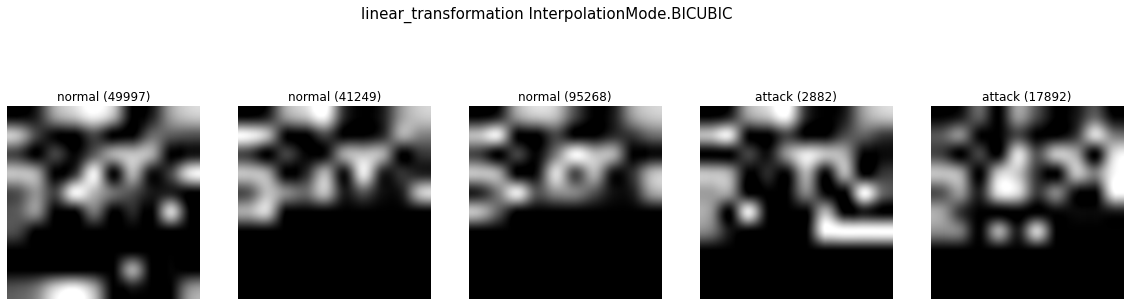

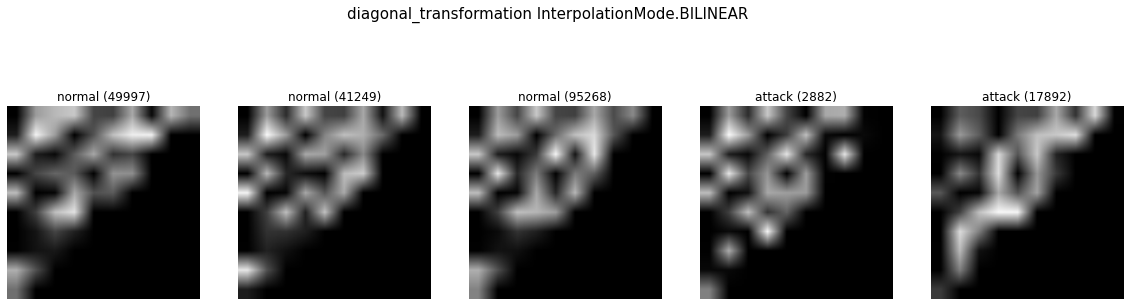

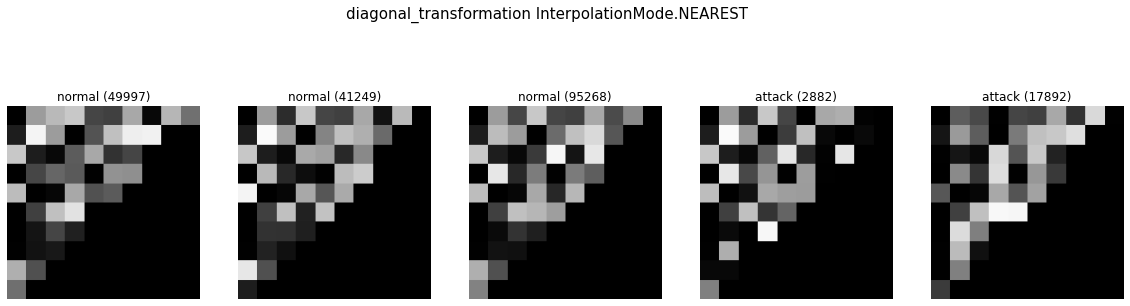

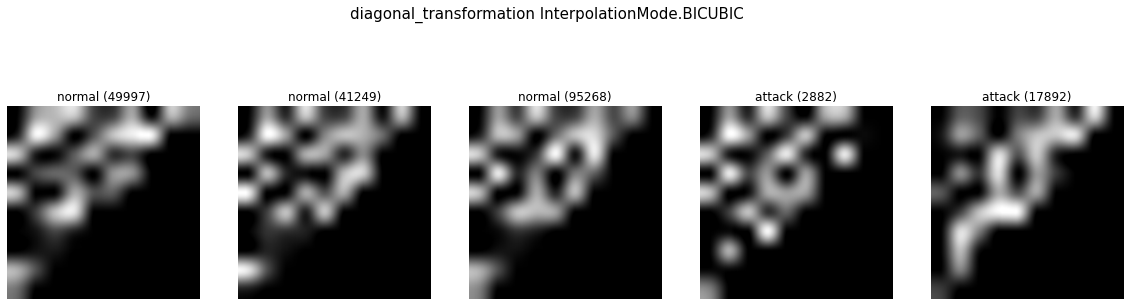

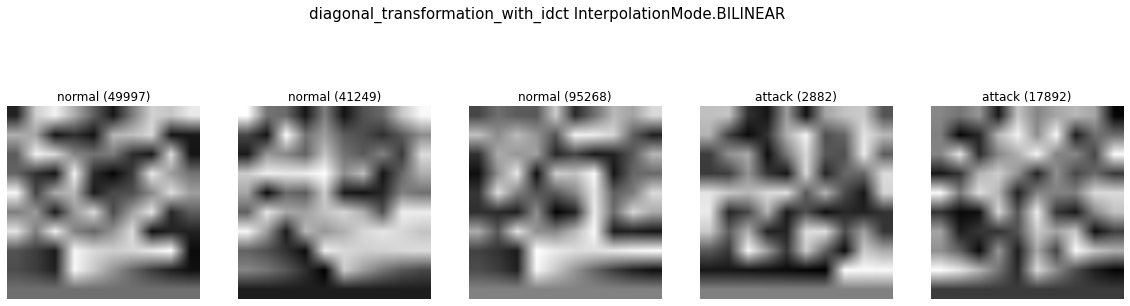

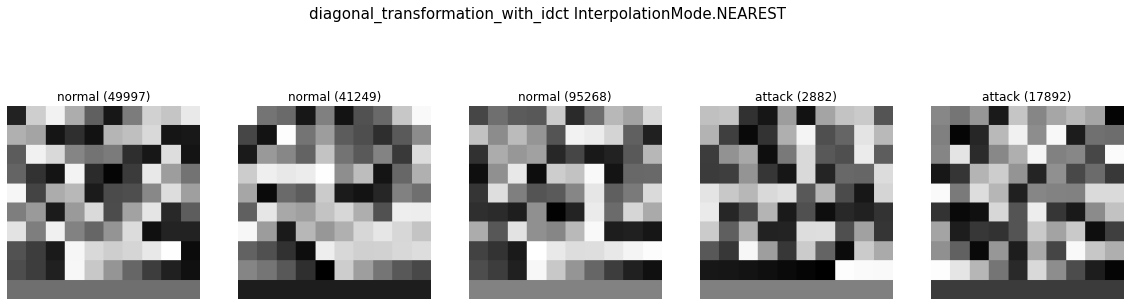

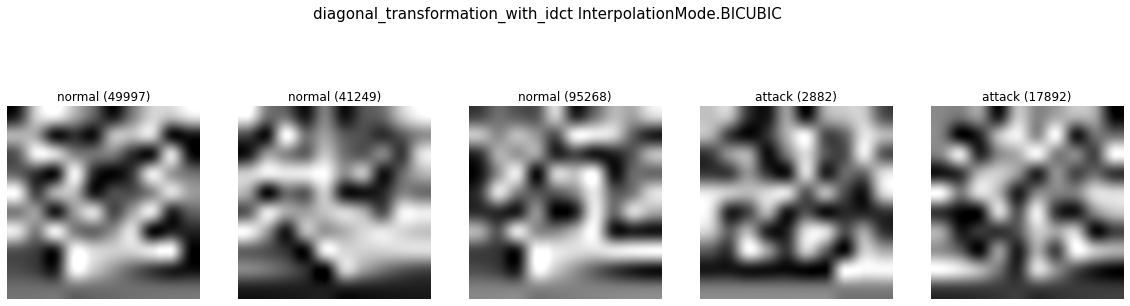

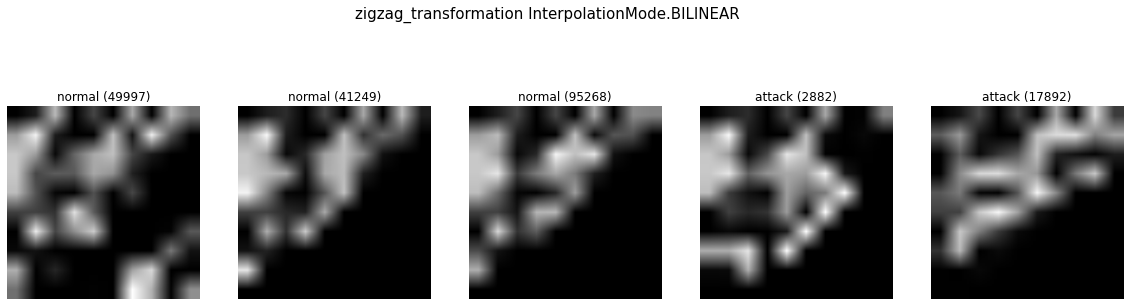

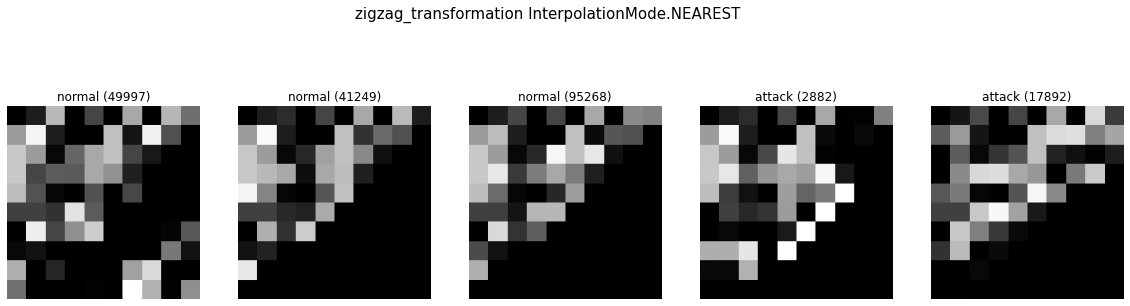

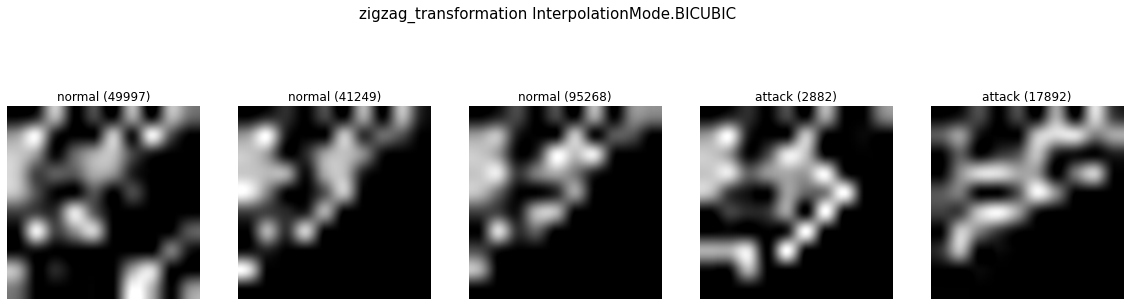

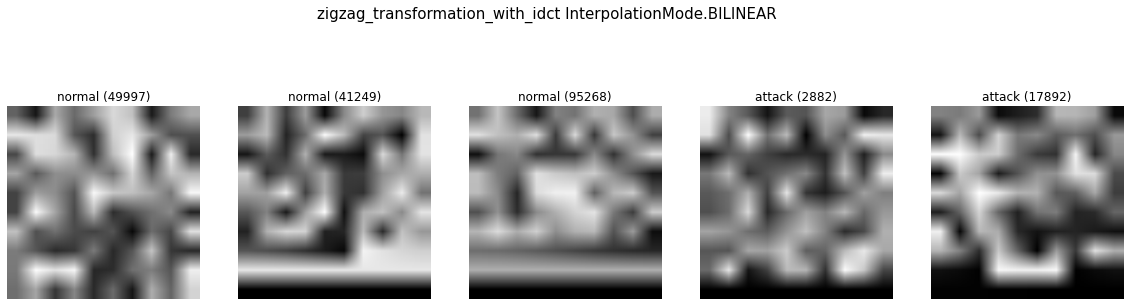

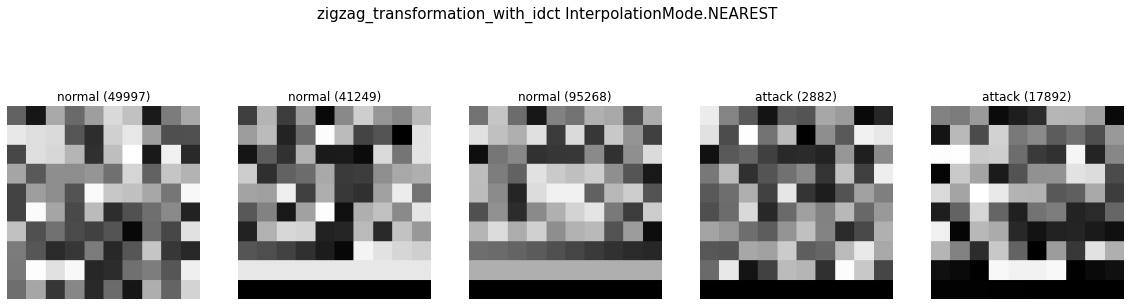

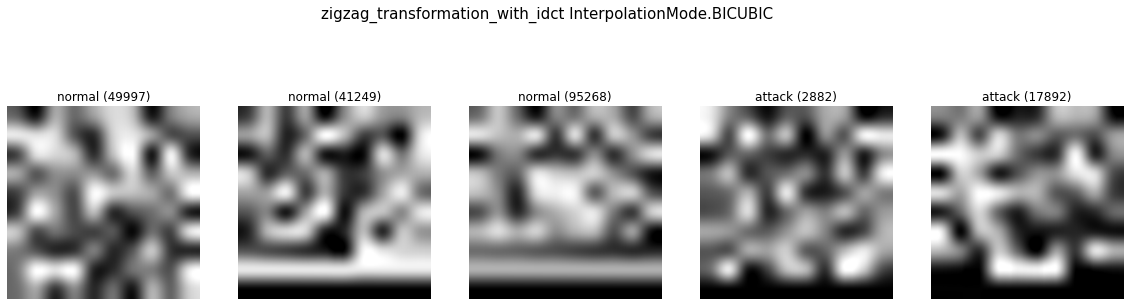

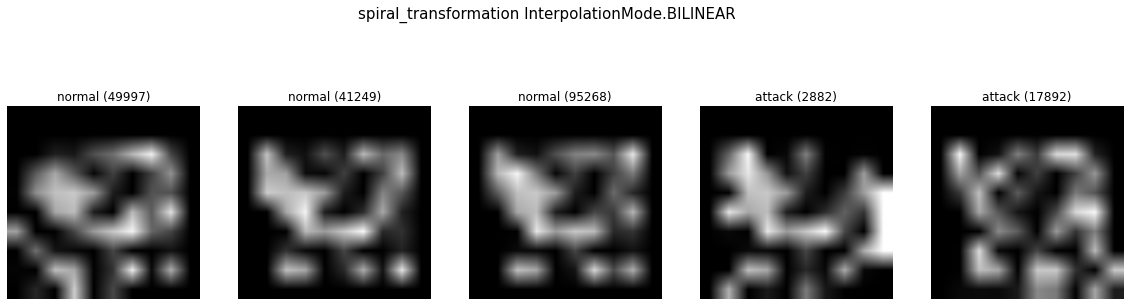

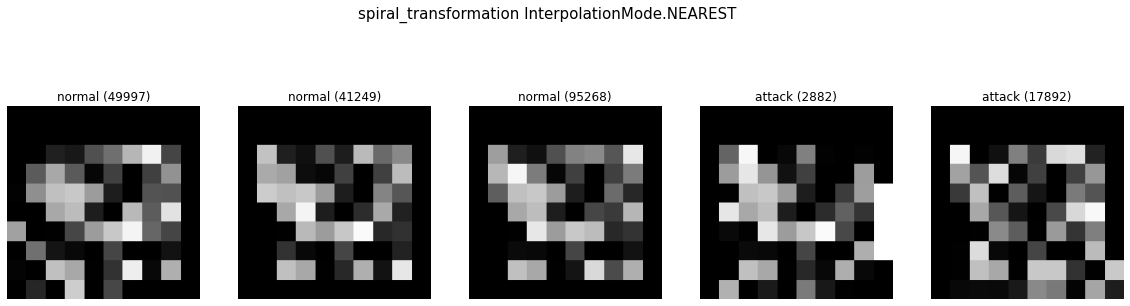

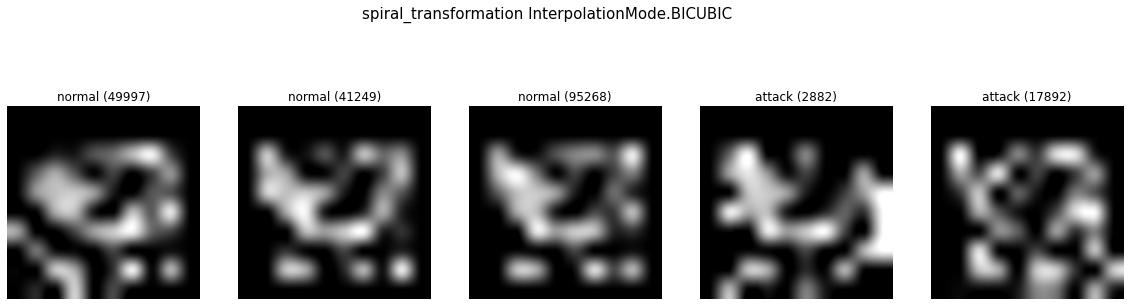

In [ ]:
random_normal = random.sample(normal_idxs_ep, 3) 
random_attack = random.sample(attack_idxs_ep, 2) 

functions = [linear_transformation, 
             diagonal_transformation, 
             diagonal_transformation_with_idct,
             zigzag_transformation,
             zigzag_transformation_with_idct, 
             spiral_transformation]

interpolation_methods = [transforms.InterpolationMode.BILINEAR,
                         transforms.InterpolationMode.NEAREST,
                         transforms.InterpolationMode.BICUBIC]

for func in functions:
  for inter_method in interpolation_methods:
    images = list()
    titles = list()
    for idx in random_normal:
      image = func(sample=test_array_ep[idx, : -offset], size=(RESOLUTION, RESOLUTION))
      resized_image = transforms.Resize(size=224, interpolation=inter_method).forward(image)
      images.append(resized_image)
      titles.append('normal (%s)' % idx)
    for idx in random_attack:
      image = func(sample=test_array_ep[idx, : -offset], size=(RESOLUTION, RESOLUTION))
      resized_image = transforms.Resize(size=224, interpolation=inter_method).forward(image)
      images.append(resized_image)
      titles.append('attack (%s)' % idx)

    fig_title = func.__name__ + ' ' + str(inter_method)
    show_images(images=images, titles=titles, fig_title=fig_title)

In [ ]:
test_sample = test_array_ep[0]
test_sample.shape

(103,)

In [ ]:
func(sample=test_array_ep[idx, : -offset], size=(RESOLUTION, RESOLUTION))

In [ ]:
fig = plt.figure(figsize=figsize)
  fig.suptitle(fig_title, fontsize=15)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.axis('off')
      plt.title(titles[i])
      plt.imshow(image)

## Show images

In [ ]:
%%time
test_array_ep = np.loadtxt('/content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/not_aggregated/dataset_ep_bin_clf_experimental.csv', delimiter=',', dtype=np.float64)
test_array_ep.shape

CPU times: user 40.4 s, sys: 4.03 s, total: 44.5 s
Wall time: 50.3 s


In [ ]:
%%time
attack_idxs_ep = list()
normal_idxs_ep = list()
idx = 0
while idx < len(test_array_ep):
  if test_array_ep[idx, -1] == 1:
    attack_idxs_ep.append(idx)
  else:
    normal_idxs_ep.append(idx)
  idx += 1

CPU times: user 91.7 ms, sys: 56.9 ms, total: 149 ms
Wall time: 153 ms


In [ ]:
RESOLUTION = 25

offset = 628 - RESOLUTION**2

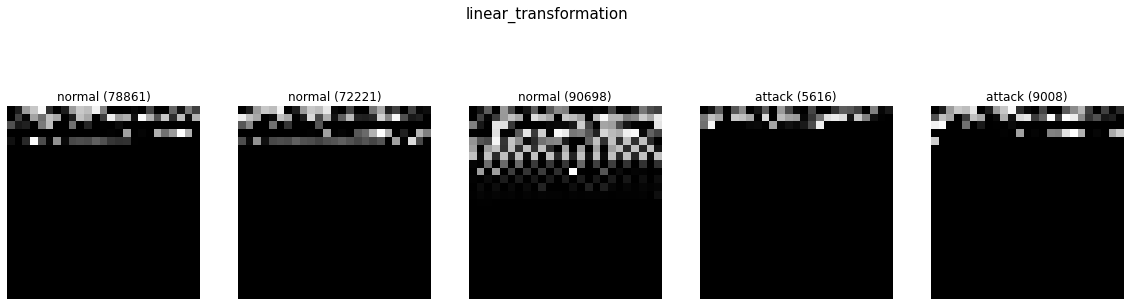

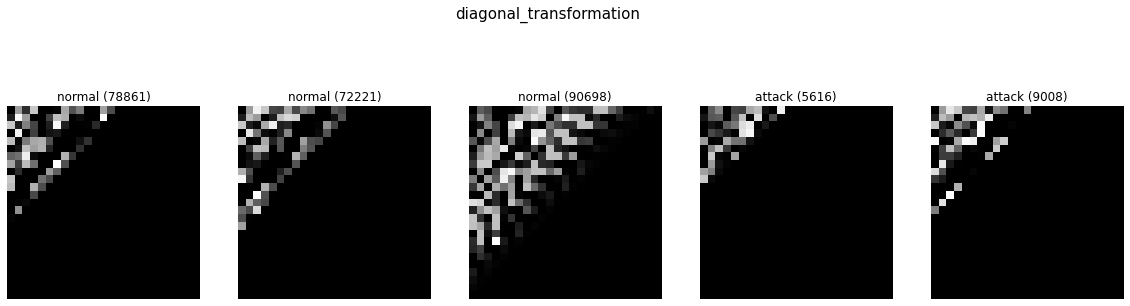

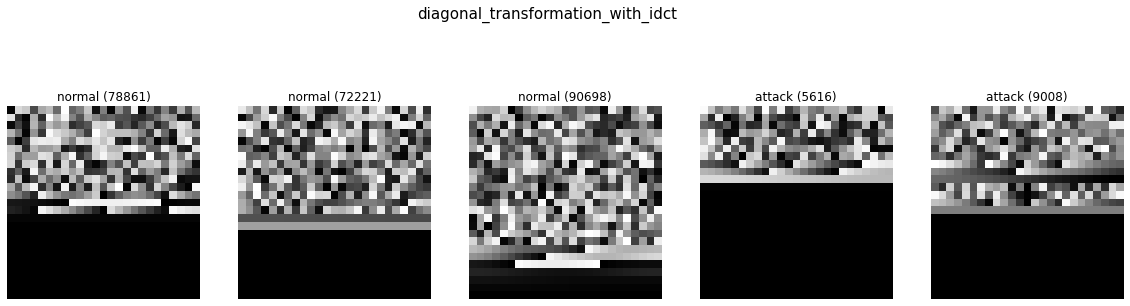

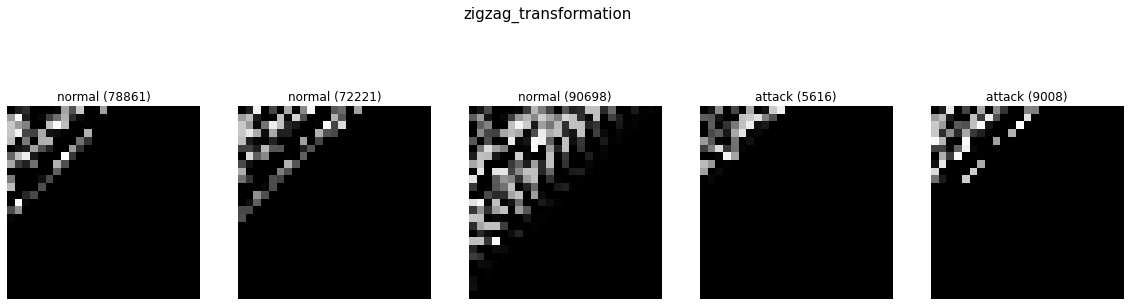

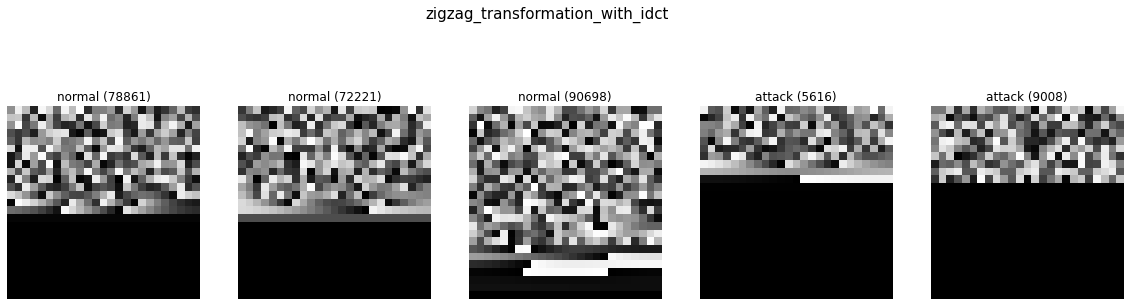

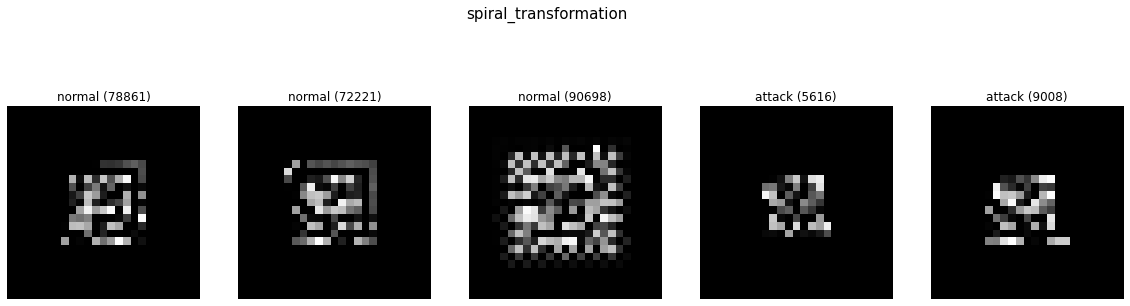

In [ ]:
random_normal = random.sample(normal_idxs_ep, 3) 
random_attack = random.sample(attack_idxs_ep, 2) 

functions = [linear_transformation, 
             diagonal_transformation, 
             diagonal_transformation_with_idct,
             zigzag_transformation,
             zigzag_transformation_with_idct, 
             spiral_transformation]

for func in functions:
  images = list()
  titles = list()
  for idx in random_normal:
    images.append(func(sample=test_array_ep[idx, : -offset], size=(RESOLUTION, RESOLUTION)))
    titles.append('normal (%s)' % idx)
  for idx in random_attack:
    images.append(func(sample=test_array_ep[idx, : -offset], size=(RESOLUTION, RESOLUTION)))
    titles.append('attack (%s)' % idx)
  show_images(images=images, titles=titles, fig_title=func.__name__)

## Prepare data to CNN

In [13]:
info_features_length = 3

### Split dataset to train/test

In [14]:
%%time
test_array_ep = np.loadtxt('/content/drive/MyDrive/Master/MW_Semenov_6381/datasets/SWaT/SWaT_2019/not_aggregated/dataset_ep_bin_clf_experimental_first121b_small.csv', delimiter=',', dtype=np.float64)

CPU times: user 1.95 s, sys: 179 ms, total: 2.13 s
Wall time: 4.47 s


In [19]:
test_array_ep.shape

(20000, 124)

In [15]:
train_experimental_ep_features, test_experimental_ep_features, train_experimental_ep_labels, test_experimental_ep_labels = train_test_split(test_array_ep[:, :-1], test_array_ep[:, -1], test_size=0.3)

In [16]:
unique_train, counts_train = np.unique(train_experimental_ep_labels, return_counts=True)
unique_test, counts_test = np.unique(test_experimental_ep_labels, return_counts=True)

In [17]:
print('Final ratios:')
print('Train=%s%%, test=%s%%' % (round(train_experimental_ep_labels.shape[0] / test_array_ep.shape[0] * 100, 2),
                                 round(test_experimental_ep_labels.shape[0] / test_array_ep.shape[0] * 100, 2)))
print('Inside train: normal=%s%%, attack=%s%%' % (round(counts_train[0] / train_experimental_ep_labels.shape[0] * 100, 2),
                                                  round(counts_train[1] / train_experimental_ep_labels.shape[0] * 100, 2)))
print('Inside test: normal=%s%%, attack=%s%%' % (round(counts_test[0] / test_experimental_ep_labels.shape[0] * 100, 2),
                                                 round(counts_test[1] / test_experimental_ep_labels.shape[0] * 100, 2)))

Final ratios:
Train=70.0%, test=30.0%
Inside train: normal=59.97%, attack=40.03%
Inside test: normal=60.07%, attack=39.93%


In [18]:
train_experimental_ep_dataset = np.concatenate((train_experimental_ep_features, train_experimental_ep_labels.reshape(-1, 1)), axis=1)
test_experimental_ep_dataset = np.concatenate((test_experimental_ep_features, test_experimental_ep_labels.reshape(-1, 1)), axis=1)

### Convert data to images and save

Select parameters

In [20]:
METHOD = zigzag_transformation  # zigzag_transformation  # linear_transformation  # spiral_transformation
DATASET_NAME = 'SWaT_Dec2019_ep_experimental_image_first121b_small'
DESTINATION_FOLDER_NAME = DATASET_NAME + '_' + METHOD.__name__
MATRIX_SIZE = int((test_array_ep.shape[1] - info_features_length)**0.5)

In [21]:
print('Max matrix size: %s' % MATRIX_SIZE)
print('Destination folder name: %s' % DESTINATION_FOLDER_NAME)

Max matrix size: 11
Destination folder name: SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation


Create destination folders

In [22]:
train_experimental_path = DESTINATION_FOLDER_NAME + '_train'
create_destination_folder(train_experimental_path)

test_experimental_path = DESTINATION_FOLDER_NAME + '_test'
create_destination_folder(test_experimental_path)

Create folder: [SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_train]
Create folder: [SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test]


In [23]:
%%time
convert_and_save(array=train_experimental_ep_dataset,
                 method=METHOD,
                 matrix_size=(MATRIX_SIZE, MATRIX_SIZE),
                 path=train_experimental_path)

Create folder: [SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_train/normal]
Create folder: [SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_train/attack]
1000 samples converted to images and saved
2000 samples converted to images and saved
3000 samples converted to images and saved
4000 samples converted to images and saved
5000 samples converted to images and saved
6000 samples converted to images and saved
7000 samples converted to images and saved
8000 samples converted to images and saved
9000 samples converted to images and saved
10000 samples converted to images and saved
11000 samples converted to images and saved
12000 samples converted to images and saved
13000 samples converted to images and saved
CPU times: user 3.82 s, sys: 791 ms, total: 4.61 s
Wall time: 4.65 s


In [24]:
%%time
convert_and_save(array=test_experimental_ep_dataset,
                 method=METHOD,
                 matrix_size=(MATRIX_SIZE, MATRIX_SIZE),
                 path=test_experimental_path)

Create folder: [SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/normal]
Create folder: [SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/attack]
1000 samples converted to images and saved
2000 samples converted to images and saved
3000 samples converted to images and saved
4000 samples converted to images and saved
5000 samples converted to images and saved
CPU times: user 1.7 s, sys: 354 ms, total: 2.06 s
Wall time: 2.06 s


In [25]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (744 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: 

In [26]:
!tree "/content/SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_train" | tail -1

2 directories, 14000 files


In [27]:
!tree "/content/SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test" | tail -1

2 directories, 6000 files


In [28]:
!tar -czvf "SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_train.tar.gz" -C "/content" "SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_train" 
!cp "/content/SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_train.tar.gz" "/content/drive/MyDrive/Master/MW_Semenov_6381/datasets/SWaT/SWaT_2019/images"

!tar -czvf "SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test.tar.gz" -C "/content" "SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test" 
!cp "/content/SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test.tar.gz" "/content/drive/MyDrive/Master/MW_Semenov_6381/datasets/SWaT/SWaT_2019/images"

Выходные данные были обрезаны до нескольких последних строк (5000).
SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/normal/1575601513.385714.jpg
SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/normal/1575601719.736364.jpg
SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/normal/1575601591.558705.jpg
SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/normal/1575601592.81819.jpg
SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/normal/1575601600.91502.jpg
SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/normal/1575601702.23041.jpg
SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/normal/1575601642.126294.jpg
SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/normal/1575601670.891342.jpg
SWaT_Dec2019_ep_experimental_image_first121b_small_zigzag_transformation_test/n